# PASOS PARA REALIZAR UN MODELO ARIMA

1. Preparación de datos:

    * Tener un dataframe con una columna de fechas llamada 'FECHA' y la columna 'ICA' que deseas predecir.
    * Asegurar de que la columna 'FECHA' esté en formato de fecha y tiempo.
    * Establecer la columna 'FECHA' como índice del dataframe

2. Comprobar si la serie es estacionaria:

    * Visualización Análisis exploratorio de datos
    * Comprobar

3. División de datos:
 
    * Dividir los datos en un conjunto de entrenamiento y un conjunto de prueba. por ej: Usar una parte de los datos existentes como entrenamiento y los últimos 15 días como prueba.
        train_data = df[:-15]
        test_data = df[-15:]

4. Construcción del modelo ARIMA:

    * Importa la biblioteca statsmodels para construir el modelo ARIMA
        from statsmodels.tsa.arima.model import ARIMA
    * Entrenar  el modelo ARIMA utilizando los datos de entrenamiento
        model = ARIMA(train_data['ICA'], order=(p, d, q))  # Reemplazar p, d, q con los parámetros    adecuados para tu modelo ARIMA
        model_fit = model.fit()

5. Realización de la predicción:
    
    * Realizar la predicción para los próximos 15 días utilizando el modelo entrenado
        prediction = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

6. Visualización de la predicción:

    * Crear un nuevo dataframe con la fecha y la predicción.
        prediction_df = pd.DataFrame({'FECHA': test_data.index, 'Prediccion_ICA': prediction})
        prediction_df.set_index('FECHA', inplace=True)
    * Graficar los datos originales y la predicción en el mismo gráfico para visualizar los resultados
        plt.figure(figsize=(15, 7))
        plt.plot(train_data['ICA'], label='Datos de entrenamiento')
        plt.plot(test_data['ICA'], label='Datos de prueba')
        plt.plot(prediction_df['Prediccion_ICA'], label='Predicción')
        plt.title('Predicción del ICA utilizando ARIMA')
        plt.xlabel('Fecha')
        plt.ylabel('ICA')
        plt.legend()
        plt.show()


## Importar librerías necesarias

In [2]:
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
# from pmdarima import ARIMA

warnings.filterwarnings("ignore")

## 1. Preparación de los datos

* Importar los datos
* Asegurar que existe una columna 'FECHA' y una columna 'ICA'
* Asegurar que la columna 'FECHA' tiene formato datetime
* Establecer la fecha como índice del dataframe

In [3]:
df = pd.read_csv('../../data/calidad_clean_outliers.csv', delimiter=',')
df = df[['FECHA', 'ICA']]
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%Y-%m-%d %H:%M:%S")
df.set_index("FECHA", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head(2)

,ICA
FECHA,
2019-01-01 05:00:00,45.22
2019-01-01 06:00:00,45.64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30860 entries, 2019-01-01 05:00:00 to 2023-05-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ICA     30860 non-null  float64
dtypes: float64(1)
memory usage: 482.2 KB


## 2. Comprobar si la serie es estacionaria

#### 2.1. Visualización: Análisis exploratorio de datos (EDA)

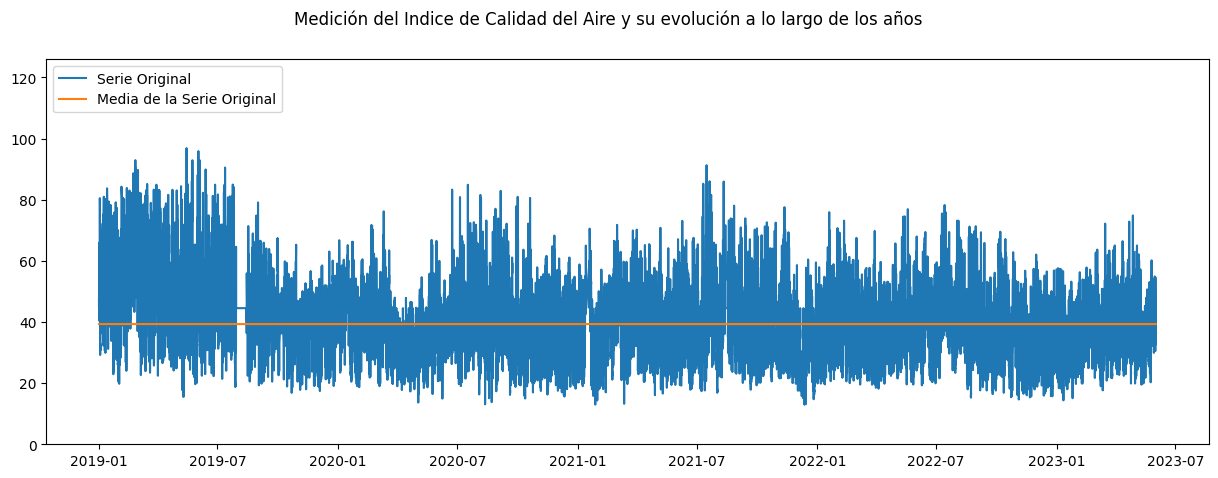

In [5]:
# separar x y la y para el gráfico
x = df.index

y = df["ICA"]
y_media = [np.mean(y) for _ in y]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (15, 5))
ax = fig.subplots(1, 1)

# la serie original parece ser estacionaria si nos fijamos en su comportamiento, ya que la media es la misma en 
# tramos diferentes de la serie.
ax.plot(x, y, label = "Serie Original")
ax.plot(x, y_media, label = "Media de la Serie Original")
ax.set_ylim(0, np.max(y)*1.3)
ax.legend(loc = "upper left")
fig.suptitle("Medición del Indice de Calidad del Aire y su evolución a lo largo de los años");

#### 2.2. Prueba estadística ADF: Comprobación de la estacionaridad de la serie 

* El objetivo de la prueba ADF es evaluar la presencia de una raíz unitaria en una serie temporal, lo que indica la presencia de tendencia y no  
  estacionariedad.

* La hipótesis nula (H0) de la prueba ADF es que la serie temporal tiene una raíz unitaria, lo que significa que es no estacionaria. 

* La hipótesis alternativa (H1) es que la serie no tiene una raíz unitaria y, por lo tanto, es estacionaria.

* El estadístico ADF se calcula comparando la tasa de cambio en los valores de la serie temporal con su propia variación aleatoria:
  - Si el estadístico ADF es menor que el valor crítico (umbral), se rechaza la hipótesis nula y se concluye que la serie es estacionaria. 
  - Si el estadístico ADF es mayor que el valor crítico, no se puede rechazar la hipótesis nula y se concluye que la serie es no estacionaria.

In [6]:
for serie, nombre_serie in zip([y], ["Serie Original"]):    
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadístico de ADF: {}".format(-2.89))
    print("Valor Crítico: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación: {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -13.69138297075373

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 1.341913606188679e-25



* ADF: Decisión a partir del resultado obtenido:

 1. Observamos p-valor < nivel significación, es decir, el estadístico ADF es menor que el valor crítico. 
 2. Por tanto, rechazamos la hipótesis nula (H0). 
 3. Conclusión:
    * LA SERIE ES ESTACIONARIA

#### 2.3.  Analizar autocorrelación y autocorrelación parcial

* LAGS: Desfases o rezagos en una serie temporal. Representan la diferencia de tiempo entre una observación y otra. 
  Por ejemplo, un lag de 1 indica la correlación entre una observación y la observación inmediatamente anterior.

* ACF (Autocorrelación): La función de autocorrelación (ACF, por sus siglas en inglés) es una medida de la correlación entre una observación 
  y sus valores rezagados a diferentes intervalos de tiempo. Representa cómo se correlaciona una serie consigo misma a medida que se desplaza en el tiempo. La ACF se utiliza para identificar patrones de correlación en una serie temporal.

* PACF (Autocorrelación parcial): La función de autocorrelación parcial (PACF, por sus siglas en inglés) mide la correlación directa entre una 
  observación y sus valores rezagados, eliminando la influencia de los valores intermedios. La PACF ayuda a determinar la correlación directa entre una observación y su rezago específico, ignorando las correlaciones indirectas.

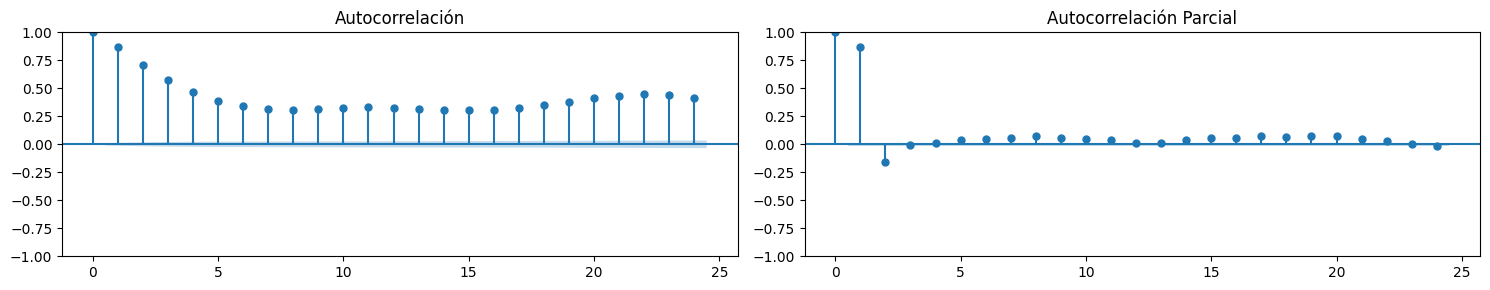

In [9]:
LAGS = 24

fig = plt.figure(figsize = (15, 3))
(ax1, ax2) = fig.subplots(1, 2)

# Gráfico de ACF(autocorrelación) y PACF(Autocorrelación Parcial)
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()

## 3. División de datos

    * train: Entrenamiento
    * test: Prueba

In [10]:
serie_a_predecir = y

# Predecir valor del ICA en los próximos 30 días
y_train = df[:-720]
y_test = df[-720:]

print(y_train.head())
print(y_test.head())

                       ICA
FECHA                     
2019-01-01 05:00:00  45.22
2019-01-01 06:00:00  45.64
2019-01-01 07:00:00  47.94
2019-01-01 08:00:00  47.78
2019-01-01 09:00:00  45.88
                       ICA
FECHA                     
2023-04-29 08:00:00  52.91
2023-04-29 10:00:00  48.99
2023-04-29 12:00:00  53.45
2023-04-29 15:00:00  36.53
2023-04-29 16:00:00  30.70


## 4.  Construcción de Modelo ARIMA

Un modelo ARIMA se repsenta como ARIMA (p, d, q) donde:

* AR (p): representa la parte "Autorregresiva" del modelo. La intuición básica consiste en que los valores pasados más próximos al momento "t", 
  tendrán mayor impacto en los valores presentes. Para determinar el orden "p" del modelo, podemos utilizar el plot de autocorrelación parcial

* I (d): representa la parte "Integral" del modelo y este parámetro del modelo nos dice cuantos diferenciaciones (restas de la serie contra si 
  misma) se tienen que llevar a cabo para convertir la serie en estacionaria.

* MA (q): representa la parte de "Medias Móviles". Como vimos, esto implica que el error del modelo se establece como una combinaciòn lineal de 
  los errores observados en el pasado. Para determinar el orden "q" del modelo, podemos utilizar el plot de autocorrelación.

El modelo básico de ARIMA se puede extender más allá incorporando la estacionalidad de la serie y variables exógenas. En este caso estaríamos hablado del modelo SARIMAX representado por (p, d, q) x (P, D, Q) S: donde los parámetros (P, D, Q) representan la misma idea que los (p, d, q) pero tratan sobre la parte estacional de la serie.

El parámetro S a su vez representa el número de periodos que tienen que pasar para que la estacionalidad se repita: 12 para meses, 4 para trimestres etc.

In [11]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# En caso de querer probar un modelo SARIMAX completo, ejecutar la siguiente línea de itertools.
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


#### 4.1 Gridsearch: Búsqueda de los parámetros óptimos para el modelo ARIMA

A continuación utilizaremos una "Gridsearch" básico para buscar los parámetros óptimos del modelo ARIMA.

* Para hacer el gridsearch, hay que calcular los posibles valores que vamos a pasarle al modelo.

* Utilizamos el modelo SARIMAX, porque en su implementaciòn en Python existen herramientas adicionales  que facilitan el análisis y que
  no están disponibles en la implementación de ARIMA.

* ARIMAX es un modelo ARIMA pero con un componente estacional (la leta S de Seasonal) y también un componente exógeno (X de eXogenous 
  regressors). Por tanto un modelo SARIMAX de (1, 1, 1) x (0, 0, 0, 0). Es un modelo ARIMA (1, 1, 1)   

In [12]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                    best_score = results.aic
                    best_params = param
                    best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)4 - AIC:309632.4481532627
ARIMA(0, 0, 1)x(0, 0, 0, 0)4 - AIC:273382.7987539612
ARIMA(0, 0, 2)x(0, 0, 0, 0)4 - AIC:249138.068450773
ARIMA(0, 1, 0)x(0, 0, 0, 0)4 - AIC:195355.4389742506
ARIMA(0, 1, 1)x(0, 0, 0, 0)4 - AIC:195130.70527137574
ARIMA(0, 1, 2)x(0, 0, 0, 0)4 - AIC:195009.84584482445
ARIMA(0, 2, 0)x(0, 0, 0, 0)4 - AIC:213733.80713331906
ARIMA(0, 2, 1)x(0, 0, 0, 0)4 - AIC:195355.60960810797
ARIMA(0, 2, 2)x(0, 0, 0, 0)4 - AIC:195130.82199415355
ARIMA(1, 0, 0)x(0, 0, 0, 0)4 - AIC:195192.11277517665
ARIMA(1, 0, 1)x(0, 0, 0, 0)4 - AIC:194935.67107664328
ARIMA(1, 0, 2)x(0, 0, 0, 0)4 - AIC:194845.18105543125
ARIMA(1, 1, 0)x(0, 0, 0, 0)4 - AIC:195165.03989751014
ARIMA(1, 1, 1)x(0, 0, 0, 0)4 - AIC:195092.84593508893
ARIMA(1, 1, 2)x(0, 0, 0, 0)4 - AIC:191929.16046793817
ARIMA(1, 2, 0)x(0, 0, 0, 0)4 - AIC:207915.30173928896
ARIMA(1, 2, 1)x(0, 0, 0, 0)4 - AIC:195165.61326479015
ARIMA(1, 2, 2)x(0, 0, 0, 0)4 - AIC:195119.593996101
ARIMA(2, 0, 0)x(0, 0, 0, 0)4 - AIC:

#### 4.2 Elección del mejor modelo ARIMA:

* El índice de AIC es Akaike Information Criterion y sirve para elegir un modelo entre un conjunto de posibles modelos.

* El índice calcula la distancia de Kullback - Leibler entre el modelo y la serie.

* Una forma de interpretar el índice es: buscamos el modelo con el menor índice porque este es el más simple que se ajusta a los datos.

In [13]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (2, 1, 2), 
Con un AIC de 191685.9841308316


#### 4.3 Entrenamiento del modelo ARIMA

In [15]:
# Entrenamos el modelo con los mejores parametros.

model = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = model.fit()

## Interpretación del mejor modelo

In [16]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3465      0.020     68.439      0.000       1.308       1.385
ar.L2         -0.5111      0.016    -32.085      0.000      -0.542      -0.480
ma.L1         -1.3776      0.021    -66.288      0.000      -1.418      -1.337
ma.L2          0.3991      0.020     19.544      0.000       0.359       0.439
sigma2        33.8653      0.177    190.860      0.000      33.518      34.213


In [ ]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

Interprentado los gráficos podemos observar lo siguiente:

    Arriba a la izquiera: los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.
    Arriba a la derecha: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).
    Abajo a la derecha: vemos que la autocorrelación parcial entre los residuos y residuos - k, dan lugar a valores no significativos. Esto implica que no "nos queda" información a extraer de los residuos, es decir el modelo no ha sido capaz de reproducir el patrón de comportamiento sistemático de la serie y habría que reformularlo.
    Abajo a la izquierda: la distrbución ordenada de los residuos sigue una Normal.

## Predicción utilizando el modelo

In [ ]:
prediction = results.predict(start=len(df), end=len(df) + 359)

In [ ]:
prediction_index = pd.date_range(start=df.index[-1], periods=360, freq='H')  # Ajusta la frecuencia 'H' según tus datos

In [ ]:
prediction_df = pd.DataFrame({'FECHA': prediction_index, 'Prediccion_ICA': prediction})
prediction_df.set_index('FECHA', inplace=True)


In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df['ICA'], label='Datos originales')
plt.plot(prediction_df['Prediccion_ICA'], label='Predicción')
plt.title('Predicción del ICA utilizando ARIMA')
plt.xlabel('Fecha')
plt.ylabel('ICA')
plt.legend()
plt.show()


In [ ]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

In [ ]:
ax = serie_a_predecir.plot(label = 'Valores reales', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Pieles Capturadas')

# Limitar el gráfico al año 2024
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-05-31'))

plt.legend()
plt.show()

In [ ]:
y_pred = pred_ci.iloc[:, 0]

In [ ]:
# El RMSE es de 2.52
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))